### Clustering with PSO

##### Import Statements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans

##### Cluster Algorithm with K-Means

In [2]:
def cluster( image, k):
    # height and width of image
    h, w, _ = image.shape

    # reshape image into matrix
    X = image.reshape( ( h * w, 3))

    # initiate KMeans
    kmeans = KMeans( n_clusters=k, n_init="auto")

    # fit to image matrix
    kmeans.fit( X)

    # labels of each pixels
    value = kmeans.labels_

    # location of centers
    centers = kmeans.cluster_centers_

    # generate new image matrix based on labels and centers
    new_X = np.array( [ np.uint8( centers[ c]) for c in value])

    # reshape new image matrix into proper image
    new_image = new_X.reshape( image.shape)

    return new_image

##### Euclidean Distance Function (Used in Fitness Function)

In [3]:
# euclidean distance between two points a and b
def euc( a, b):
	return np.sum( [ ( a[ i] - b[ i]) ** 2 for i in range( len( a))]) ** 0.5

##### Fitness Function

In [4]:
# X: image matrix
# p: loaction of particle
def pso_cluster_fit( X, p):
	# number of pixels
	n = X.shape[ 0]

	# number of clusters
	k = int( p.shape[ 0] / 3)

	# centers
	centers = p.reshape( ( 3, k)).T

	# labels for each pixel
	labels = np.zeros( n)

	# distance between of each pixel with each cluster
	dists = np.zeros( ( n, k))

	# for each cluster
	for i in range( k):
		# calculate distance between pixels and cluster
		dists[:,i] = np.sum( ( X - centers[ i]) ** 2, axis=1) ** 0.5

	# nearest cluster number as label of pixel
	labels = dists.argmin( axis=1)

	# nearest cluster distance
	min_dist = dists.min( axis=1)

	# value of fitness function
	f = min_dist.sum()

	return f, labels, centers

##### PSO Cluster Function

In [5]:
# image: Input Image for Clustering
# w: inertia weight
# c1: cognitive coefficient
# c2: global coefficient
# n_iter: number of iterations
def pso_cluster( image, k, w=0.7, c1=1, c2=1, n_iter=50):
	# height and width of image
	H, W, _ = image.shape

	# reshaping image into matrix
	X = image.reshape( ( H * W, 3))

	# number of pixels
	n = X.shape[ 0]

	# dimensions
	d = k * 3

	# number of particles
	pn = d

	# maximum range of search space for each dimension
	domain = 255

	# location of particles. initial seed within [ 0, domain]
	p = domain * np.random.rand( pn, d)
	
	# initial velocity
	v = np.zeros( ( pn, d))

	# best location of particle initiated with p ( initial location)
	pbest = np.copy( p)

	# value of fit function for each particle
	f = np.array( [ pso_cluster_fit( X, particle)[ 0] for particle in p])

	# best value of fit function for each particle
	# initiated with f ( initial value of fit function for each particle)
	fpbest = np.copy( f)

	# best value of fit function among all particles
	# and its corresponding location
	fgbest, gbest = f.min(), p[ f.argmin()]

	# variable for recording history of fgbest (best value of fit function)
	history = np.zeros( n_iter)

	# iterate n_iter time
	for i in range( n_iter):

		# recording best value of fit function
		history[ i] = fgbest

		# generate two matrices of random numbers in range [ -1, 1] and shape of ( pn, d) ( for each particle and for each dimension)
		r1 = np.random.rand( pn, d)
		r2 = np.random.rand( pn, d)

		# calculate velocity of particles in each dimenstion
		v = ( w * v) + ( r1 * c1 * ( pbest - p)) + ( r2 * c2 * ( gbest - p))

		# update position of particle
		p = p + v

		# keep values in range
		p[ p < 0] = 0
		p[ p > 255] = 255

		f = np.array( [ pso_cluster_fit( X, particle)[ 0] for particle in p])

		# find indices of particles with better value of fit function than their previous value
		indices = np.nonzero( f < fpbest)

		# update value of fit function for particles that found a better value
		fpbest[ indices] = f[ indices]

		# update position of particles that found a better value
		pbest[ indices] = p[ indices]
		
		# if f.min() < fgbest:
		# update best value and its corresponding location
		fgbest, gbest = f.min(), p[ f.argmin()]

	# acquire labels and centers from gbest
	_, value, centers = pso_cluster_fit( X, gbest)

	# generate new image matrix based on labels and centers
	new_X = np.array( [ np.uint8( centers[ c]) for c in value])

    # reshape new image matrix into proper image
	new_image = new_X.reshape( image.shape)

	return new_image, history, fgbest, value, centers


##### Driver

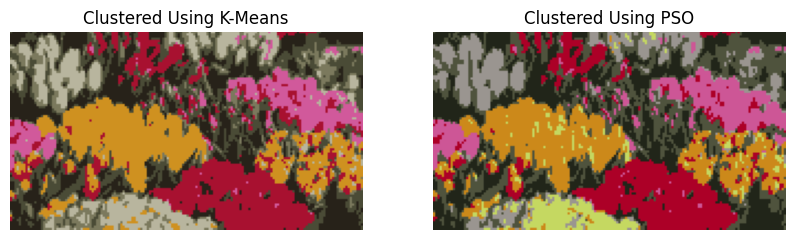

In [6]:
IMG_PATH = "IMG/flower.jpg"
IMG_SIZE = ( 160, 90)
CLUSTERS = 7

img = np.array( Image.open( IMG_PATH).resize( IMG_SIZE))

img_clustered1 = cluster( img, CLUSTERS)
img_clustered2, history, fgbest, _, centers = pso_cluster( img, CLUSTERS)

fig = plt.figure( figsize=( 10, 10))

fig.add_subplot( 1, 2, 1)
plt.title( "Clustered Using K-Means")
plt.imshow( img_clustered1)
plt.axis( "off")

fig.add_subplot( 1, 2, 2)
plt.title( "Clustered Using PSO")
plt.imshow( img_clustered2)
plt.axis( "off")

plt.show()

##### Plot History

Best Value: 608796.1999079257
Centers:
[[172.12000062   0.          39.89776635]
 [205.39908377  86.38463427 150.48950717]
 [204.66294534 137.04250869  26.11782976]
 [154.81188472 149.77086542 144.31061898]
 [ 79.97874525  83.35045596  61.76395687]
 [197.03390729 216.02519821  97.15561429]
 [ 33.57070851  37.44093141  25.25188253]]


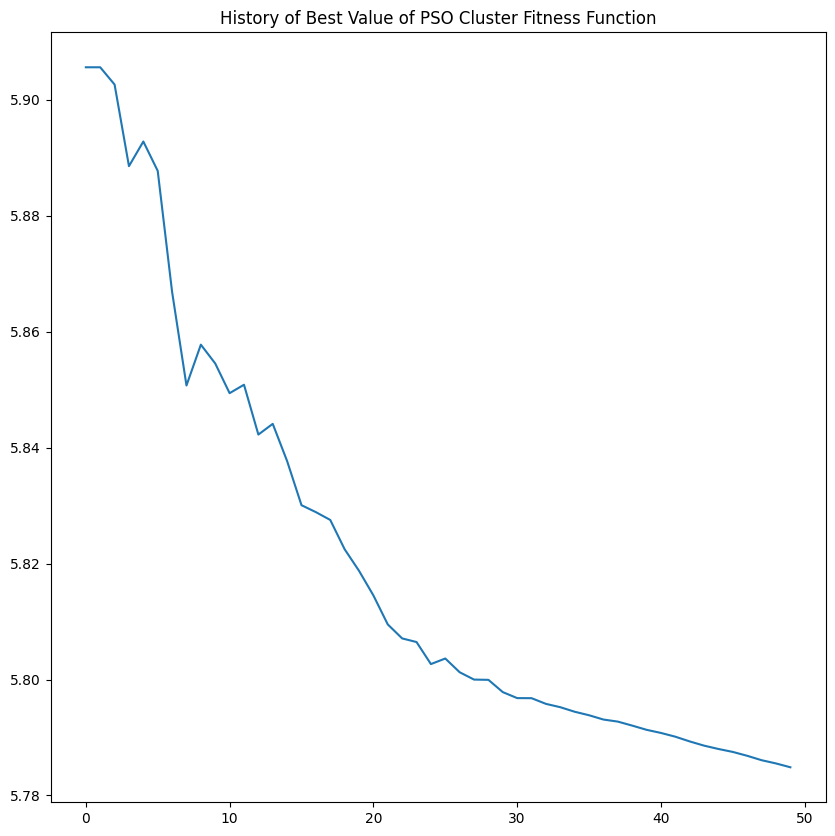

In [7]:
print( f"Best Value: { fgbest}")
print( f"Centers:\n{ centers}")

plt.figure( figsize=( 10, 10))
plt.title( "History of Best Value of PSO Cluster Fitness Function")
plt.plot( np.log10( history))
plt.show()